In [1]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'


2024-11-14 14:57:39.657736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 14:57:39.712759: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

if gpus:
    try:
        # GPU 메모리 사용량을 제한할 크기(MB 단위)
        memory_limit = 46068 / 4  # 예: 4GB로 제한

        # GPU마다 메모리 제한 설정
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
        print(f"GPU 메모리 사용량이 {memory_limit}MB로 제한되었습니다.")
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 메모리 사용량이 11517.0MB로 제한되었습니다.


In [3]:
import os

os.environ['CUDA_HOME']='/home/j-k11s207/.conda/envs/lsh'
os.environ['LD_LIBRARY_PATH']='/home/j-k11s207/.conda/envs/lsh/lib'


# TensorFlow 및 기본 라이브러리 로드
TensorFlow와 필요한 기본 라이브러리를 불러오고, 재현 가능한 결과를 위해 시드를 설정합니다.

In [4]:
# 코랩 설정: TensorFlow 및 기본 라이브러리 로드
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# 데이터셋 로드 및 경로 설정
데이터셋 경로를 설정하고, `audio_dataset_from_directory` 함수를 사용해 오디오 데이터를 불러옵니다.


In [5]:

# 데이터셋 로드 및 저장 경로 설정
DATASET_PATH = '../dataset/stt_test'
data_dir = pathlib.Path(DATASET_PATH)


`audio_dataset_from_directory` 함수를 사용해 오디오 데이터셋을 불러옵니다.  

데이터는 훈련(`train_ds`)과 검증(`val_ds`) 세트로 나뉘며, 16개의 샘플로 이루어진 배치로 로드됩니다.

sample_rate는 16Khz로 고정되며 **target_length(총길이)** = sample_rate * time_rate로 계산됩니다.

전체 데이터의 20%는 검증 세트로 사용되며, 각 오디오 샘플의 길이는 `target_length`로 고정됩니다.

In [6]:
# # 데이터셋 로드 및 저장 경로 설정

sample_rate = 16000  # 목표 샘플링 레이트
time_rate = 2 # 몇초 음성
target_length = sample_rate * time_rate

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=target_length,
    subset='both',
)


Found 8930 files belonging to 6 classes.
Using 7144 files for training.
Using 1786 files for validation.


2024-11-14 14:57:41.401200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 14:57:41.502337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11517 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:ca:00.0, compute capability: 8.9


# 데이터셋 라벨 확인 및 트리거 단어 설정
훈련 및 검증 데이터셋의 클래스 이름을 확인하고, 트리거 단어로 설정된 `hey_ssafy`를 출력합니다.


In [7]:

label_names = np.array(train_ds.class_names)

trigger_word = "augmented_audio"

# 레이블 이름 출력
print("\n========== Label Names ==========")
for idx, name in enumerate(label_names):
    print(f"{idx + 1}. {name}")

# 트리거 단어 출력
print("\n========== Trigger Word ==========")
print(trigger_word)



========== Label Names ==========
1. augmented_audio
2. falseAudioPre
3. falseHap
4. hey
5. noise
6. pgg

========== Trigger Word ==========
augmented_audio


학습 데이터와 호출어의 Label을 확인합니다.
호출어가 바뀐경우 trigger_word 변수를 수정해줍니다.

# 클래스 분포 시각화
훈련 및 검증 데이터셋의 클래스 분포를 확인하고, 이를 시각화합니다.


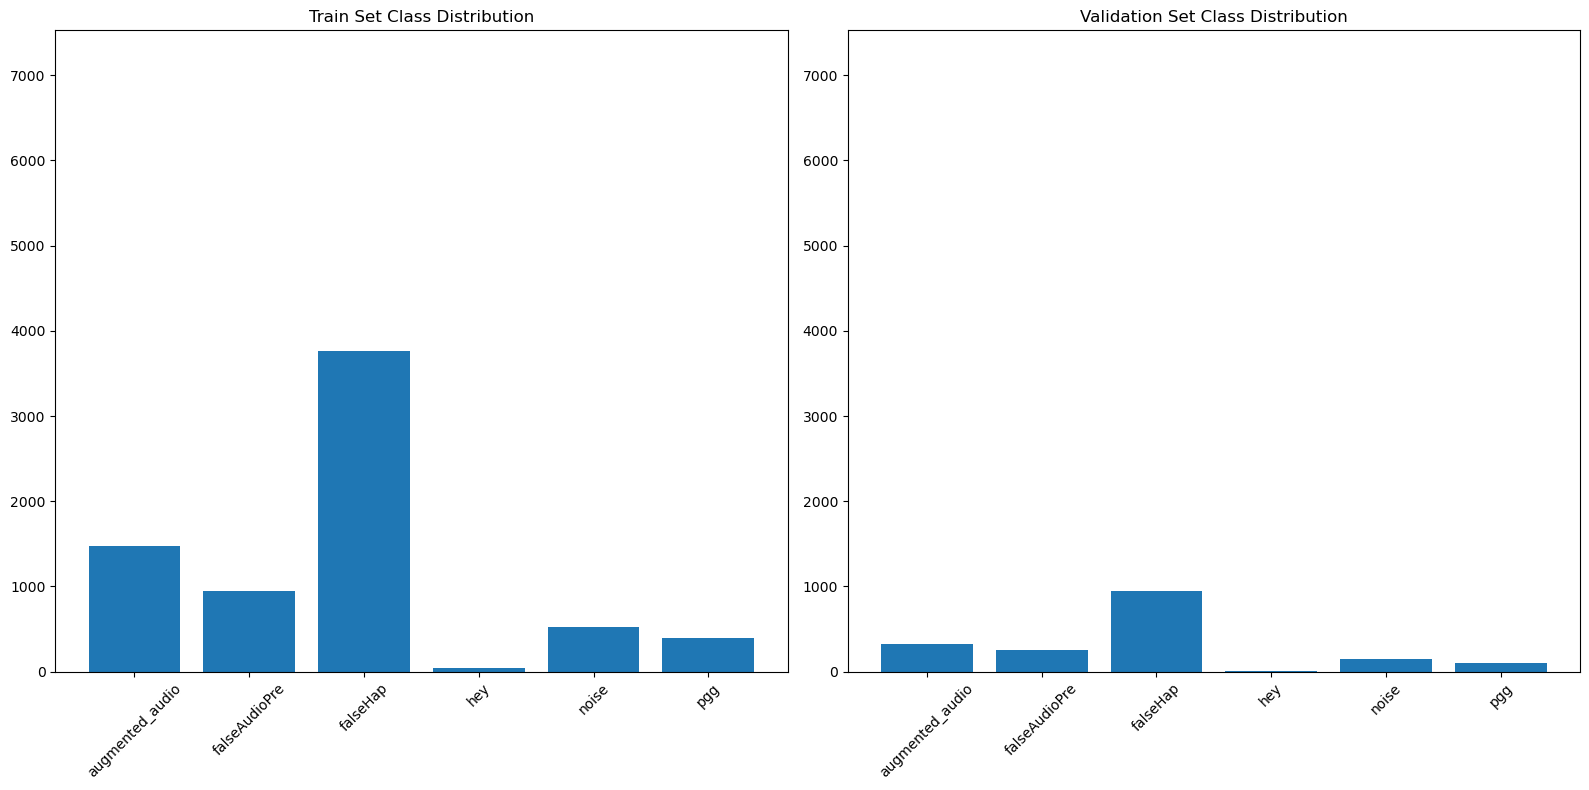

In [8]:
from collections import Counter
# 훈련 데이터셋 클래스 분포 확인
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

train_class_distribution = Counter(train_labels)

# 검증 데이터셋 클래스 분포 확인
val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())

val_class_distribution = Counter(val_labels)

# 클래스 분포 시각화
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.bar(train_class_distribution.keys(), train_class_distribution.values())
plt.ylim(0, max(train_class_distribution.values()) * 2)
plt.title('Train Set Class Distribution')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=45)

plt.subplot(1, 2, 2)
plt.bar(val_class_distribution.keys(), val_class_distribution.values())
plt.ylim(0, max(train_class_distribution.values()) * 2)
plt.title('Validation Set Class Distribution')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=45)

plt.tight_layout()
plt.show()


# 트리거 워드를 기준으로 이진 레이블 설정
트리거 워드와 매칭되는 오디오에는 1, 다른 오디오에는 0으로 설정하는 함수를 정의하여 이진 분류 문제로 변환합니다.

In [9]:
# 트리거 워드를 기준으로 레이블을 설정하는 함수
def relabel_classes(audio, label):
    # trigger_word와 같은 이름의 폴더는 1, 아닌 것은 0으로 설정
    trigger_index = np.where(label_names == trigger_word)[0][0]
    binary_label = tf.where(label == trigger_index, 1, 0)
    return audio, binary_label, label;

# 레이블 변환 적용
train_ds = train_ds.map(relabel_classes, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(relabel_classes, num_parallel_calls=tf.data.AUTOTUNE)


# 샘플 시각화 및 오디오 재생
테스트를 위해 트리거 단어와 다른 클래스 샘플을 각각 3개씩 추출하여 시각화하고, 오디오 재생 버튼을 통해 직접 들을 수 있게 합니다.

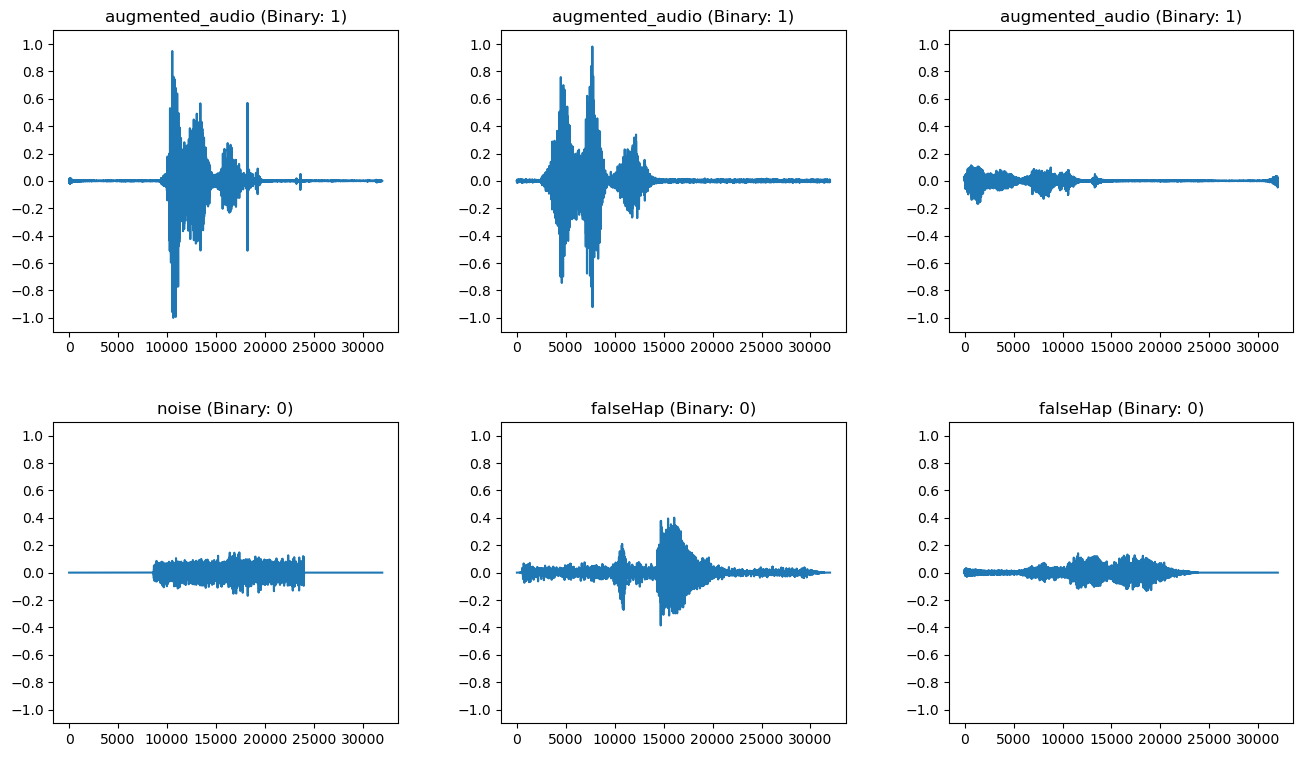


========== Audio Playback ==========
Audio for augmented_audio (Binary: 1):


Audio for augmented_audio (Binary: 1):


Audio for augmented_audio (Binary: 1):


Audio for noise (Binary: 0):


Audio for falseHap (Binary: 0):


Audio for falseHap (Binary: 0):


In [10]:
from IPython.display import Audio, display

# 첫 줄에 trigger_word 샘플, 그 다음 줄에 다른 클래스 샘플 표시
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

trigger_samples, other_samples = [], []

# train_ds에서 trigger_word 샘플과 다른 클래스 샘플을 분리
for audio, binary_label, original_label in train_ds:

    for i in range(len(binary_label)):
        label_name = label_names[original_label[i].numpy()]
        sample = (audio[i].numpy(), label_name, binary_label[i].numpy())

        # 샘플을 조건에 맞게 수집
        if label_name == trigger_word and len(trigger_samples) < 3:
            trigger_samples.append(sample)
        elif label_name != trigger_word and len(other_samples) < 3:
            other_samples.append(sample)

        # 필요한 샘플 수를 모두 모으면 종료
        if len(trigger_samples) == 3 and len(other_samples) == 3:
            break
    if len(trigger_samples) == 3 and len(other_samples) == 3:
        break

# 첫 번째 줄: trigger_word 샘플, 두 번째 줄: 다른 클래스 샘플
for row, samples in enumerate([trigger_samples, other_samples]):
    for i, (waveform, label_name, binary_label_val) in enumerate(samples):
        ax = axes[row][i]
        ax.plot(waveform)
        ax.set_title(f"{label_name} (Binary: {binary_label_val})")
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        ax.set_ylim([-1.1, 1.1])

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 그림 간격 조정
plt.show()

# 각 그래프 아래에 오디오 출력 버튼 표시
print("\n========== Audio Playback ==========")
for row, samples in enumerate([trigger_samples, other_samples]):
    for i, (waveform, label_name, binary_label_val) in enumerate(samples):
        print(f"Audio for {label_name} (Binary: {binary_label_val}):")
        # wave 데이터를 1차원으로 변환하여 오디오 재생
        display(Audio(waveform.flatten(), rate=16000))


# 데이터 전처리 함수
오디오 데이터에서 불필요한 차원을 제거하고, STFT로 스펙트로그램을 생성하는 함수를 정의합니다.


In [11]:
# squeeze 함수 수정
def squeeze(audio, binary_label, original_label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, binary_label

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


In [12]:
train_ds = train_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

`squeeze` 함수를 통해 데이터셋의 오디오 데이터 차원을 축소하고, `test_ds`와 `val_ds`를 나눕니다.

# 샘플 데이터 확인 및 스펙트로그램 생성
데이터셋에서 변환된 레이블과 스펙트로그램 형태가 기대한 결과가 맞는지 확인합니다.

In [13]:
# IPython의 display와 Audio 모듈 import
from IPython.display import display, Audio

# 변환된 이진 레이블 이름 설정
print("Original label names:", label_names)

# 특정 샘플에서 변환된 레이블과 이진 레이블 확인
for example_audio, example_binary_label in train_ds.take(1):  # 첫 배치 샘플 확인
    for i in range(4):  # 처음 10개 샘플 확인
        # 이진 라벨 가져오기
        binary_label_val = example_binary_label[i].numpy()  # 이진 라벨 직접 가져오기
        label_name = label_names[binary_label_val]  # 이진 라벨을 사용해 원래 클래스 이름 가져오기

        # 출력: 이진 라벨, 원래 클래스 이름, 스펙트로그램
        print(f"Sample {i+1}\n - Binary Label: {binary_label_val}\n - Original Label: {label_name}\n")

        waveform = example_audio[i]
        spectrogram = get_spectrogram(waveform)
        print('Waveform shape:', waveform.shape)
        print('Spectrogram shape:', spectrogram.shape)

        # 오디오 파일 재생
        display(Audio(waveform, rate=16000))


Original label names: ['augmented_audio' 'falseAudioPre' 'falseHap' 'hey' 'noise' 'pgg']
Sample 1
 - Binary Label: 0
 - Original Label: augmented_audio

Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)


Sample 2
 - Binary Label: 0
 - Original Label: augmented_audio

Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)


Sample 3
 - Binary Label: 0
 - Original Label: augmented_audio

Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)


Sample 4
 - Binary Label: 0
 - Original Label: augmented_audio

Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)


# 스펙트로그램 데이터셋 변환
데이터셋의 오디오 데이터를 스펙트로그램 형식으로 변환하여 새로운 데이터셋으로 만듭니다.


In [14]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda *args: (get_spectrogram(args[0]), args[1]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)



라벨별 샘플을 시각화하고, 오디오를 직접 재생하여 확인합니다.

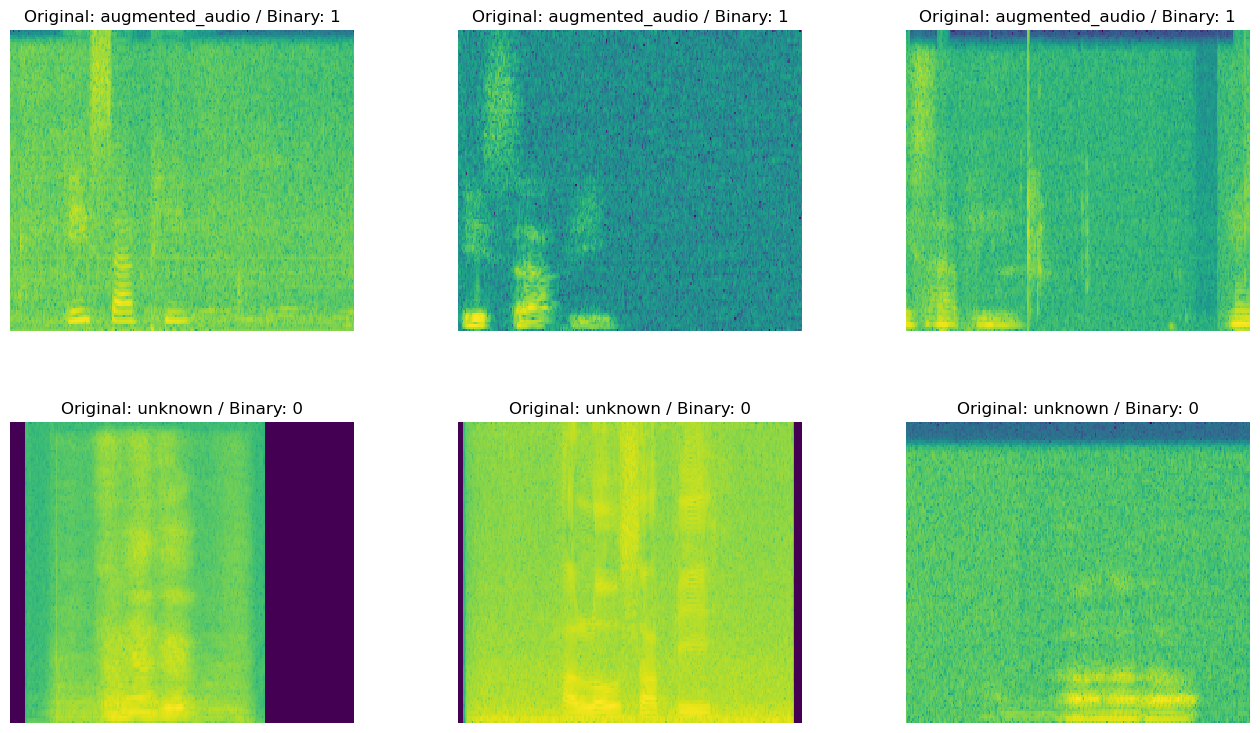


========== Audio Playback ==========
Audio for Original: augmented_audio / Binary: 1:


Audio for Original: augmented_audio / Binary: 1:


Audio for Original: augmented_audio / Binary: 1:


Audio for Original: unknown / Binary: 0:


Audio for Original: unknown / Binary: 0:


Audio for Original: unknown / Binary: 0:


In [15]:
import random
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# 라벨 1 샘플과 라벨 0 샘플을 각각 3개씩 무작위로 선택
label_one_samples, label_zero_samples = [], []

# train_ds에서 라벨이 1인 샘플과 0인 샘플을 분리하고 무작위로 선택
for example_waveforms, binary_labels in train_ds:
    for i in range(len(binary_labels)):
        sample = (example_waveforms[i].numpy().squeeze(), binary_labels[i].numpy())

        # 라벨이 1인 샘플을 수집
        if sample[1] == 1 and len(label_one_samples) < 3:
            label_one_samples.append(sample)
        # 라벨이 0인 샘플을 수집
        elif sample[1] == 0 and len(label_zero_samples) < 3:
            label_zero_samples.append(sample)

        # 필요한 샘플 수를 모두 모으면 종료
        if len(label_one_samples) == 3 and len(label_zero_samples) == 3:
            break
    if len(label_one_samples) == 3 and len(label_zero_samples) == 3:
        break

# 시각화 및 오디오 재생
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

# 첫 번째 줄에 라벨 1 샘플, 두 번째 줄에 라벨 0 샘플 표시
for row, samples in enumerate([label_one_samples, label_zero_samples]):
    for col, (waveform, binary_label_val) in enumerate(samples):
        ax = axes[row][col]

        # 스펙트로그램 생성
        spectrogram = get_spectrogram(waveform)

        # 스펙트로그램 시각화
        plot_spectrogram(spectrogram.numpy(), ax)
        label_text = f"Original: {trigger_word if binary_label_val == 1 else 'unknown'} / Binary: {binary_label_val}"
        ax.set_title(label_text)
        ax.axis("off")

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 그림 간격 조정
plt.show()

# 각 그래프 아래에 오디오 출력 버튼 표시
print("\n========== Audio Playback ==========")
for row, samples in enumerate([label_one_samples, label_zero_samples]):
    for col, (waveform, binary_label_val) in enumerate(samples):
        label_text = f"Original: {trigger_word if binary_label_val == 1 else 'unknown'} / Binary: {binary_label_val}"
        print(f"Audio for {label_text}:")
        display(Audio(waveform, rate=16000))


In [16]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


모델을 훈련하는 동안 읽기 지연 시간을 줄이기 위해 Dataset.cache 및 Dataset.prefetch 작업을 추가합니다.

### **스펙트로그램 변환 및 전처리**

tf.keras.layers.Lambda(get_spectrogram): 오디오 데이터를 스펙트로그램으로 변환합니다.
- layers.Resizing(32, 32): 입력 이미지를 32x32로 다운샘플링하여 처리 속도를 높입니다.
- norm_layer: 평균과 표준 편차로 정규화하여 안정적인 학습을 돕습니다.


### **컨볼루션 블록**

- 총 3개의 컨볼루션 블록으로, 각각 특징 추출을 위한 Conv2D, - BatchNormalization, MaxPooling2D 레이어로 구성됩니다.

- Conv Block 5에서 MaxPooling2D(pool_size=(4, 1))로 시간 축을 줄여줍니다.

### **드롭아웃**

layers.Dropout(0.5)
- 과적합 방지를 위해 학습 시 50%의 뉴런을 무작위로 비활성화합니다.

출력 레이어
- layers.Dense(1, activation='sigmoid'): 이진 분류를 위한 시그모이드 활성화 함수로 구성된 출력 레이어입니다.

In [17]:

import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (32000, )  # 입력 파라미터 shape
print('Input shape:', input_shape)

# Normalization Layer 설정
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
model = models.Sequential([
    layers.Input(shape=input_shape),
    tf.keras.layers.Lambda(get_spectrogram),
    layers.Resizing(32, 32),
    norm_layer,
    
    # Conv Block 1
    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    layers.Dropout(0.1),  # 각 블록에 작은 드롭아웃 추가
    
    # Conv Block 2
    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    layers.Dropout(0.1),
    
    # Conv Block 3
    layers.Conv2D(64, kernel_size=3, padding='same'),  # 필터 수 감소
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
    layers.Dropout(0.1),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(32, activation='relu'),  # 뉴런 수 더 감소
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Input shape: (32000,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 249, 129, 1)       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                    

Adam 옵티마이저와 교차 엔트로피 손실을 사용하여 Keras 모델을 구성합니다.

In [18]:
# 모델 컴파일 - 이진 분류에 맞춰 수정
model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # 시그모이드 출력을 사용하기 때문에 from_logits=False
    metrics=['accuracy'],
    # weighted_metrics=[]  # 이 줄을 추가하여 경고 해제
)

In [19]:

EPOCHS = 300

# 모델 학습
history = model.fit(
    train_ds,  # 훈련 데이터셋
    validation_data=val_ds,  # 검증 데이터셋
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=30)],
)

Epoch 1/300


2024-11-14 14:57:47.079181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-11-14 14:57:47.645519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


112/112 [==============================] - 5s 29ms/step - loss: 0.2998 - accuracy: 0.8977 - val_loss: 0.6600 - val_accuracy: 0.5966
Epoch 2/300
112/112 [==============================] - 2s 18ms/step - loss: 0.1003 - accuracy: 0.9839 - val_loss: 1.4167 - val_accuracy: 0.3854
Epoch 3/300
112/112 [==============================] - 2s 18ms/step - loss: 0.0609 - accuracy: 0.9894 - val_loss: 1.3590 - val_accuracy: 0.5180
Epoch 4/300
112/112 [==============================] - 2s 18ms/step - loss: 0.0403 - accuracy: 0.9930 - val_loss: 0.7335 - val_accuracy: 0.7596
Epoch 5/300
112/112 [==============================] - 2s 18ms/step - loss: 0.0245 - accuracy: 0.9965 - val_loss: 0.0360 - val_accuracy: 0.9955
Epoch 6/300
112/112 [==============================] - 3s 26ms/step - loss: 0.0231 - accuracy: 0.9961 - val_loss: 0.0086 - val_accuracy: 0.9989
Epoch 7/300
112/112 [==============================] - 2s 16ms/step - loss: 0.0204 - accuracy: 0.9954 - val_loss: 0.0069 - val_accuracy: 0.9989
Epoc

최대 epoch(300번) 학습 반복을 설정합니다.

EarlyStopping 을 설정하여 검증 성능이 30 에포크 동안 개선되지 않으면 학습을 자동으로 종료하여 과적합을 방지합니다.



# 학습 결과 시각화
모델 학습의 정확도와 손실 추이를 시각화하여 학습 성능을 확인합니다.


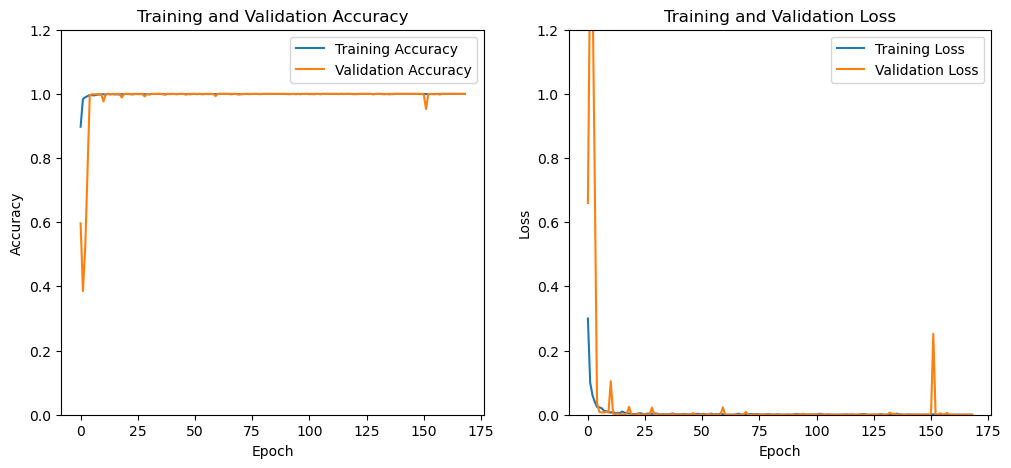

In [22]:
import matplotlib.pyplot as plt

# 학습 및 검증 정확도와 손실 그래프
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.2])
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1.2])
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# history 객체를 전달하여 그래프 출력
plot_training_history(history)


학습된 모델을 테스트 데이터셋(test_ds)으로 평가하고, 예측 값과 실제 값을 기반으로 혼동 행렬(confusion matrix)을 생성하여 시각화합니다. 혼동 행렬을 통해 모델이 올바르게 분류한 경우와 오분류한 경우를 한눈에 파악할 수 있습니다

14/14 [==============================] - 0s 7ms/step


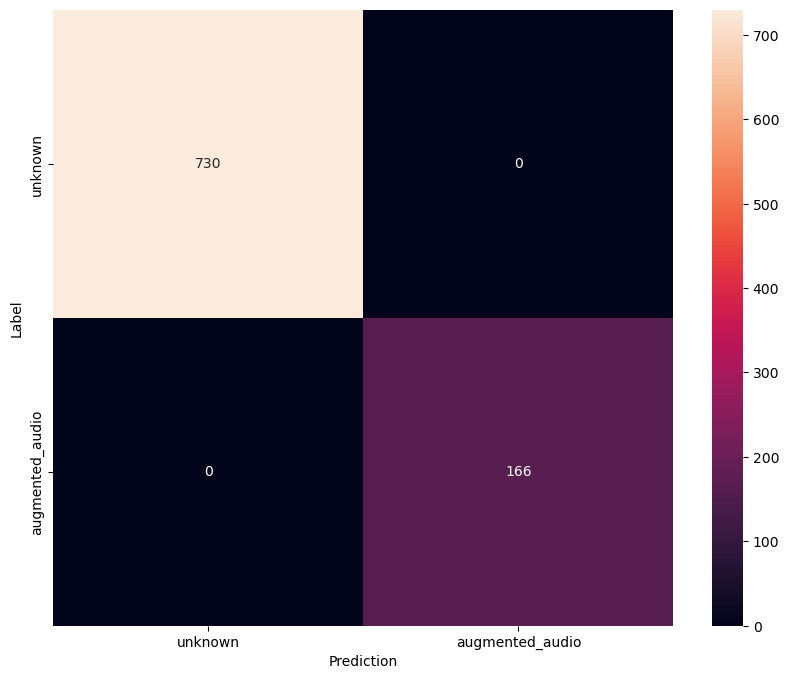

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 평가
model.evaluate(test_ds, return_dict=True)

# 예측 수행 - 시그모이드 출력을 이진화
y_pred = model.predict(test_ds)
y_pred = tf.round(y_pred).numpy().astype(int)  # 0 또는 1로 변환

# 실제 레이블 추출
y_true = tf.concat(list(test_ds.map(lambda s, lab: lab)), axis=0).numpy()

# 혼동 행렬 계산
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
xticklabels=['unknown', trigger_word],
yticklabels=['unknown', trigger_word],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


classification_report를 사용해 모델의 정밀도, 재현율, f1-score 등 성능 지표를 출력합니다.

- Precision (정밀도): 모델이 해당 클래스로 예측한 샘플 중 실제로 맞는 비율입니다. 오탐(false positive)을 줄이는 지표로, 높은 정밀도는 모델이 정확하게 예측했음을 의미합니다.

- Recall (재현율): 실제 해당 클래스인 샘플 중 모델이 맞게 예측한 비율입니다. 놓친(true positive) 예측이 적을수록 재현율이 높습니다.

- F1-score: 정밀도와 재현율의 조화 평균으로, 두 지표의 균형을 맞춥니다. f1-score가 높을수록 정밀도와 재현율이 균형 있게 우수한 모델입니다.

- Support: 각 클래스의 실제 샘플 개수를 나타내며, 성능 평가에 필요한 데이터의 분포를 제공합니다.



In [24]:
from sklearn.metrics import classification_report

# classification_report를 이용하여 성능 지표 출력
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['unknown', trigger_word]))

Classification Report:
                 precision    recall  f1-score   support

        unknown       1.00      1.00      1.00       730
augmented_audio       1.00      1.00      1.00       166

       accuracy                           1.00       896
      macro avg       1.00      1.00      1.00       896
   weighted avg       1.00      1.00      1.00       896



지정한 오디오 파일을 불러와 모델이 해당 파일을 예측하도록 하고, 예측 결과를 출력한 후 오디오를 재생합니다.

모델이 성공적으로 이진불류를 수행하고있는지 실제 음성데이터 기반으로 직접 테스트를 진행합니다.

In [24]:
from IPython.display import Audio, display  # display 함수와 Audio 함수를 가져옴

x = data_dir / 'hey_ssafy/hey_ssafy_101.wav'

print(x)

# Read the audio file
audio_binary = tf.io.read_file(str(x))
waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=32000)
waveform = tf.squeeze(waveform, axis=-1)  # Remove the channel dimension

print("waveform:", waveform)

# Print the shape after squeeze
print("Shape after squeeze:", waveform.shape)

# Expand dimensions to match the model's input shape
waveform = waveform[tf.newaxis, ...]

# Print the shape after adding the new dimension
print("Shape after adding new dimension:", waveform.shape)

# Make prediction by directly feeding the waveform to the model
prediction = model(waveform)

print(tf.round(prediction).numpy().squeeze())

# Softmax or Sigmoid activation depends on the model's output layer (use sigmoid for binary classification)
predicted_label = tf.round(prediction).numpy().squeeze()  # 예측 값을 0 또는 1로 변환

# 실제 레이블
actual_label = 1

print(f"Prediction: {predicted_label}, Actual: {actual_label}")

# Accuracy 계산 (1이면 일치, 0이면 불일치)
accuracy = 1 if predicted_label == actual_label else 0
print(f"Accuracy for this sample: {accuracy}")

# Plot the prediction probability (assuming sigmoid output)
plt.bar(['unknown', trigger_word], [1 - predicted_label, predicted_label])
plt.title(f'Prediction: {trigger_word if predicted_label else "unknown"}')
plt.show()

# Play the audio using IPython.display's Audio and display
display(Audio(waveform[0], rate=16000))


../dataset/stt_test/hey_ssafy/hey_ssafy_101.wav


2024-11-14 14:55:37.882700: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: ../dataset/stt_test/hey_ssafy/hey_ssafy_101.wav; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} ../dataset/stt_test/hey_ssafy/hey_ssafy_101.wav; No such file or directory [Op:ReadFile]

Keras 모델을 TensorFlow Lite 모델로 변환합니다.

**experimental_new_converter** = True: 새로운 TFLite 변환기를 활성화하여 최신 변환 방식을 사용합니다.

**target_spec.supported_ops**: 변환 중에 지원할 연산자를 지정합니다.
TFLITE_BUILTINS: TFLite의 기본 연산자만 사용해 변환합니다.

**SELECT_TF_OPS**: TensorFlow Flex 연산자를 사용하여, TFLite에서 기본 지원하지 않는 연산자도 포함시킵니다. 기본연산자만으로 변환에 어려움이 있을경우 사용합니다.

위와같은 설정들을 통해 TFLite가 모든 모델 연산을 변환할 수 있게 되어 변환 호환성을 높입니다.

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # 기본 연산자 사용
    tf.lite.OpsSet.SELECT_TF_OPS  # TensorFlow Flex 연산자 사용
]
tflite_model = converter.convert()
open("arg_test.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfwdyohbx/assets


INFO:tensorflow:Assets written to: /tmp/tmpfwdyohbx/assets
2024-11-14 15:04:09.015362: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-11-14 15:04:09.015384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-11-14 15:04:09.015530: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfwdyohbx
2024-11-14 15:04:09.018449: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-11-14 15:04:09.018461: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfwdyohbx
2024-11-14 15:04:09.030129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-11-14 15:04:09.032813: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-11-14 15:04:09.099944: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

248764